<a href="https://colab.research.google.com/github/yashfirkedata/DL-Critical-Heat-Flux-Prediction/blob/main/Critical_Heat_Flux_Prediction_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np

In [25]:
df= pd.read_csv('https://raw.githubusercontent.com/yashfirkedata/DL-Critical-Heat-Flux-Prediction/main/Data_CHF_Zhao_2020_ATE.csv')
df

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0
...,...,...,...,...,...,...,...,...,...,...
1860,1861,Richenderfer,plate,1.01,1500,-0.0218,15.0,120.0,10,9.4
1861,1862,Richenderfer,plate,1.01,1500,-0.0434,15.0,120.0,10,10.4
1862,1863,Richenderfer,plate,1.01,2000,-0.0109,15.0,120.0,10,10.8
1863,1864,Richenderfer,plate,1.01,2000,-0.0218,15.0,120.0,10,10.9


# **Data Preprocessing**

In [26]:
df = df.drop(['id'],axis=1)

In [27]:
new_column_names = ['author', 'geometry', 'pressure', 'mass_flux', 'exit_concentration', 'equivalent_diameter', 'hydraulic_diameter', 'channel_length', 'exp_critical_heat_flux']
df.columns = new_column_names

In [28]:
df.drop(["author"],axis=1,inplace=True)
# author can be dropped as from EDA, we can see three different authors contributed to gather 3 seperate geo study data

In [29]:
df.drop(["geometry"],axis=1,inplace=True)
# eda revealed geometry is not much of importance

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pressure                1865 non-null   float64
 1   mass_flux               1865 non-null   int64  
 2   exit_concentration      1865 non-null   float64
 3   equivalent_diameter     1865 non-null   float64
 4   hydraulic_diameter      1865 non-null   float64
 5   channel_length          1865 non-null   int64  
 6   exp_critical_heat_flux  1865 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 102.1 KB


In [31]:
df.duplicated().any()

True

In [32]:
df.drop_duplicates(inplace = True)

In [33]:
df.duplicated().any()

False

In [34]:
df.isna().sum().any()

False

**As suggested in the paper, we need to gain
Unity Variance and Zero Mean (approx)**

In [35]:
# mean of all the columns
df.mean()

pressure                     9.863929
mass_flux                 2895.929774
exit_concentration           0.018447
equivalent_diameter          9.443993
hydraulic_diameter          16.736100
channel_length             938.381312
exp_critical_heat_flux       3.878062
dtype: float64

In [36]:
# variance of all the cols
df.var()

pressure                  1.870167e+01
mass_flux                 2.705712e+06
exit_concentration        1.356412e-02
equivalent_diameter       4.202919e+01
hydraulic_diameter        4.796055e+02
channel_length            5.556513e+05
exp_critical_heat_flux    4.078113e+00
dtype: float64

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop('exit_concentration', axis=1)
y = df['exit_concentration']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=101, shuffle=True)
# Note that we are Shuffleing the data.............................................................^^^^^^^^^^^^

# Now the Val and Test Splits: 5 % for testing 15 for validating
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.3, random_state=101, shuffle=True)

In [38]:
# We need to standardize the data in such a way that mean becomes 0 and standard deviation becomes 1 approximately
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [39]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Save the datasets to CSV files
X_train_scaled_df.to_csv('X_train.csv', index=False)
X_val_scaled_df.to_csv('X_val.csv', index=False)
X_test_scaled_df.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

> Data Preprocessing Completed and Data is now ready for Modelling

# **Machine Learning Modelling**

We will be checking results on validation data.

In [40]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost Regressor": XGBRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Support Vector Machine": SVR(),
    "Gradient Boosting": GradientBoostingRegressor()
}

model_list = []
rmse_list = []

for model_name, model in models.items():

    model.fit(X_train_scaled_df, y_train)

    y_train_pred = model.predict(X_train_scaled_df)
    y_val_pred = model.predict(X_val_scaled_df)

    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)

    # Print results
    print(model_name)
    print('Model performance for Train set:')
    print('- Root Mean Squared Error (RMSE): {:.4f}'.format(rmse_train))
    print('Model performance for val set:')
    print('- Root Mean Squared Error (RMSE): {:.4f}'.format(rmse_val))
    print('='*35)
    print('\n')

    model_list.append(model_name)
    rmse_list.append(rmse_val)

# Print the final results
for i in range(len(model_list)):
    print(f"{model_list[i]}: Val RMSE = {rmse_list[i]:.4f}")


Linear Regression
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0746
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0749


XGBoost Regressor
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0091
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0495


Decision Tree
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0025
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0627


Random Forest
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0145
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0479


K-Nearest Neighbors
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0359
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0541


Support Vector Machine
Model performance for Train set:
- Root Mean Squared Error (RMSE): 0.0517
Model performance for val set:
- Root Mean Squared Error (RMSE): 0.0568


Gradi

In [41]:
pd.DataFrame(list(zip(model_list, rmse_list)), columns=['Model Name', 'rmse_list']).sort_values(by=["rmse_list"],ascending=True)

,Model Name,rmse_list
3,Random Forest,0.047921
1,XGBoost Regressor,0.049491
6,Gradient Boosting,0.052820
4,K-Nearest Neighbors,0.054142
5,Support Vector Machine,0.056769
2,Decision Tree,0.062730
0,Linear Regression,0.074854


**We can see Random Forest giving best results:**

RMSE: 0.0479, We have to try to beat this using Deep Learning

**Author Models:**
![Author Results](https://github.com/yashfirkedata/DL-Critical-Heat-Flux-Prediction/blob/c21419b76ede2748cb29b3c4c26c5ab5ffaf53b6/images/author_models.png?raw=true)


## **Random Forest Model:**



In [42]:
from sklearn.ensemble import RandomForestRegressor

rf_paper_model = RandomForestRegressor(
    n_estimators=100,           # 100 trees
    max_features=0.7,           # 50% to 70% features for each tree
    bootstrap=True,             # Default is True, sampling with replacement
    random_state=42
)

# Train the classifier
rf_paper_model.fit(X_train_scaled_df, y_train)

y_val_pred = rf_paper_model.predict(X_val_scaled_df)

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.05


In [43]:
from joblib import dump
dump(rf_paper_model, 'rf_paper_model.joblib')

['rf_paper_model.joblib']

> Applying same architecture of Random Forest model on Data as paper, we get RMSE as 0.53

# **Deep Learning Modelling**

### **Paper Architecture:**
NN Architecture: 6|50|50|50|1

In [44]:
import keras
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError as RMSE
from keras.models import Sequential
from keras import layers

# Define the model
paper_model = Sequential([
    layers.Dense(6, input_dim = 6, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
paper_model.compile(loss='mean_squared_error',
                    optimizer=optimizer,
                    metrics=[RMSE()])

# Fit the model
paper_history = paper_model.fit(
    x=X_train_scaled_df,
    y=y_train,
    epochs=600,
    validation_data=(X_val_scaled_df, y_val),
    batch_size=32
)


Epoch 1/600
44/44 [==============================] - 2s 8ms/step - loss: 0.1300 - root_mean_squared_error: 0.3606 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 2/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 3/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 4/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 5/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1057
Epoch 6/600
44/44 [==============================] - 0s 5ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - val_loss: 0.0106 - val_root_m

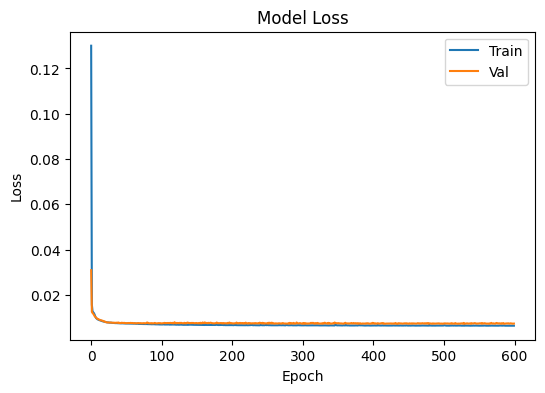

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(paper_history.history['loss'])
plt.plot(paper_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')
plt.show()

In [47]:
y_pred = paper_model.predict(X_test_scaled_df)
# Chekc the RMSE using keras.metrics.RootMeanSquaredError()
rmse = RMSE()
rmse.update_state(y_test,y_pred)
print('RMSE:',rmse.result().numpy())

4/4 [==============================] - 0s 10ms/step
RMSE: 0.13530353


In [48]:
paper_model.save('../content/CHF_paper_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
